# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy import ndimage
from scipy.io import loadmat
from scipy import stats
import pandas as pd
import random
import time
import json
import os
import nibabel as nib
import pickle as pk
from scipy import interpolate

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

#In your imports you are mixing keras and tf.keras, which are NOT compatible with each other, as you get weird errors like these.

#So a simple solution is to choose keras or tf.keras, and make all imports from that package, and never mix it with the other.

# read battery MRI data

In [ ]:
rscale=np.array([7.40000000e-05, 1.97920635e-03, 3.88441270e-03, 5.78961905e-03,
       7.69482540e-03, 9.60003175e-03, 1.15052381e-02, 1.34104444e-02,
       1.53156508e-02, 1.72208571e-02, 1.91260635e-02, 2.10312698e-02,
       2.29364762e-02, 2.48416825e-02, 2.67468889e-02, 2.86520952e-02,
       3.05573016e-02, 3.24625079e-02, 3.43677143e-02, 3.62729206e-02,
       3.81781270e-02, 4.00833333e-02, 4.19885397e-02, 4.38937460e-02,
       4.57989524e-02, 4.77041587e-02, 4.96093651e-02, 5.15145714e-02,
       5.34197778e-02, 5.53249841e-02, 5.72301905e-02, 5.91353968e-02,
       6.10406032e-02, 6.29458095e-02, 6.48510159e-02, 6.67562222e-02,
       6.86614286e-02, 7.05666349e-02, 7.24718413e-02, 7.43770476e-02,
       7.62822540e-02, 7.81874603e-02, 8.00926667e-02, 8.19978730e-02,
       8.39030794e-02, 8.58082857e-02, 8.77134921e-02, 8.96186984e-02,
       9.15239048e-02, 9.34291111e-02, 9.53343175e-02, 9.72395238e-02,
       9.91447302e-02, 1.01049937e-01, 1.02955143e-01, 1.04860349e-01,
       1.06765556e-01, 1.08670762e-01, 1.10575968e-01, 1.12481175e-01,
       1.14386381e-01, 1.16291587e-01, 1.18196794e-01, 1.20102000e-01])
cscale=np.array([0.001     , 0.00229032, 0.00358065, 0.00487097, 0.00616129,
       0.00745161, 0.00874194, 0.01003226, 0.01132258, 0.0126129 ,
       0.01390323, 0.01519355, 0.01648387, 0.01777419, 0.01906452,
       0.02035484, 0.02164516, 0.02293548, 0.02422581, 0.02551613,
       0.02680645, 0.02809677, 0.0293871 , 0.03067742, 0.03196774,
       0.03325806, 0.03454839, 0.03583871, 0.03712903, 0.03841935,
       0.03970968, 0.041     ])

# set up grid for mag-suscept map

In [ ]:
battery_dims=np.array([5,30,40])*1e-3;
cell_dims=np.array([5,50,60])*1e-3;
# probe_dist=1.59e-4; 
npts=[1,16,32];
dV=np.prod(cell_dims/npts); 

In [ ]:
1.59e1

15.9

In [ ]:
# re-adjust for centering-----------------------------------------------------------------------------------------------------------------------------
# for first data
centery=0.021;
centerz=0.06;

# for second data
centery=0.015;
centerz=0.077;

# for damaged cell data
centery=0.020;
centerz=0.065;

# for new send data
centery=0.021;
centerz=0.062;

# convert both the magnetic susceptibility grid positions and the magnetic field positions into lists of the form `[x1,y1,z1; x2,y2,z2; etc ]`

In [ ]:
# for mag-suscep
srcpos=[[],[],[]]
for i in range(3):
    srcpos[i]=np.linspace(0,cell_dims[i],npts[i]+2)
    srcpos[i]=srcpos[i][1:(npts[i]+1)]
# recenter all y and z coordinates
srcpos[1]=srcpos[1]+centery-cell_dims[1]/2
srcpos[2]=srcpos[2]+centerz-cell_dims[2]/2

srcxv,srcyv,srczv=np.meshgrid(srcpos[0],srcpos[1],srcpos[2],indexing='ij')

src_fulllength=np.prod(npts)
src_pos_list=np.concatenate((srcxv.reshape((src_fulllength,1)),srcyv.reshape((src_fulllength,1)),
                             srczv.reshape((src_fulllength,1))),axis=1)

In [ ]:
rv, cv = np.meshgrid(rscale, cscale, indexing='ij')
fulllength=np.prod(rv.shape)
# field_pos_list=np.concatenate((cv.reshape((fulllength,1)),rv.reshape((fulllength,1))),axis=1)
# field_pos_list=np.insert(field_pos_list,0,probe_dist,axis=1)

In [ ]:
[0.5e-2 * i for i in range(1,6)]

[0.005, 0.01, 0.015, 0.02, 0.025]

In [ ]:
# make a dictionary of all the different field_pos_lists generated with different probe_distances

field_dict = dict()
dist_list = [0.5e-2 * i for i in range(1,6)]
  # 5mm to 20 mm with 5mm increments

for dist in dist_list:
  probe_dist=dist
  print(probe_dist)
  field_pos_list=np.concatenate((cv.reshape((fulllength,1)),
                                rv.reshape((fulllength,1))
                                ),
                                axis=1)
  field_pos_list=np.insert(field_pos_list,0,probe_dist,axis=1)

  field_dict[dist] = field_pos_list

print(100*'*')

0.005
0.01
0.015
0.02
0.025
****************************************************************************************************


In [ ]:
field_dict.keys()

dict_keys([0.005, 0.01, 0.015, 0.02, 0.025])

In [ ]:
field_dict[0.005] == field_dict[0.02]

array([[False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       ...,
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True]])

# set up conversion matrix between magn. susceptibility and magn. field
so that we have $\mathbf{B}(field)=A \cdot \mathbf{m} (suscept)$ as a matrix-vector multiplication

In [ ]:
# modified for multidim to include multiple field components (y-z)
# now modif for x-y-z source dims

oneD=False   # to do z-only calc in this framework for magnetic susceptibility (may be more stable)

# make a dict of different A tensors generated by different mag-field tensors
A_dict = dict()

for key in field_dict.keys():
  field_pos_list = field_dict[key]

  # make sure to reshape such that multiply the correct field components
  # A matrix is not very sparse, so maybe faster to do in non-sparse setup
  fpl=field_pos_list.shape[0]
  A=np.zeros((2,field_pos_list.shape[0],src_pos_list.shape[0],3),dtype=float)
  for i in range(src_pos_list.shape[0]):
    # for every point in the source position, aka cell grid 
      posdiff=src_pos_list[i,:]-field_pos_list
        # this is a broadcasted operation
        # posdiff is field_pos_list but every row is subtracted from ths ith row in suscept_pos_list
      inv_r=1/np.sqrt(np.sum(posdiff**2,axis=1))
        # performed for each row
      inv_r5=inv_r**5
      inv_r3=inv_r**3
      
      for fidx in range(2):
          fidx2=fidx+1    # this is the real dim index (compatible with sidx)
                          # since I only have y and z components of the field
          
          if oneD:
              sidx=2
              A[fidx,:,i,sidx]=3*posdiff[:,fidx2]*posdiff[:,sidx]*inv_r5
              # A[0, :, i, 2] = 3*posdiff[:,1]*posdiff[:,2] * inv_r5
              # A[1, :, i, 2] = 3*posdiff[:,2]*posdiff[:,2] * inv_r5
              if sidx==fidx2:
                  A[fidx,:,i,sidx]=A[fidx,:,i,sidx]-inv_r3
                  #A[1, :, i, 2] = A[1, :, i, 2] - inv_r3
          else:
              for sidx in range(3):
                  A[fidx,:,i,sidx]=3*posdiff[:,fidx2]*posdiff[:,sidx]*inv_r5
                  #A[0, :, i, 0] = 3*posdiff[:, 1] * posdiff[:,0] * inv_r5
                  #A[0, :, i, 1] = 3*posdiff[:, 1] * posdiff[:,1] * inv_r5
                  #A[0, :, i, 2] = 3*posdiff[:, 1] * posdiff[:,2] * inv_r5
                  #A[1, :, i, 0] = 3*posdiff[:, 2] * posdiff[:,0] * inv_r5
                  #A[1, :, i, 1] = 3*posdiff[:, 2] * posdiff[:,1] * inv_r5
                  #A[1, :, i, 2] = 3*posdiff[:, 2] * posdiff[:,2] * inv_r5
                  if sidx==fidx2:
                      A[fidx,:,i,sidx]=A[fidx,:,i,sidx]-inv_r3
                      #A[0, :, i, 1] = A[0, :, i, 1] - inv_r3
                      #A[1, :, i, 2] = A[1, :, i, 2] - inv_r3
      
  A_dict[key]=A.reshape((fpl*2,src_pos_list.shape[0]*3))

In [ ]:
assert A_dict.keys() == field_dict.keys()

In [ ]:
assert np.any(A_dict[0.005] != A_dict[0.025])

In [ ]:
for key in A_dict.keys():
  # proper conversion units
  B0=20e-6
  A_dict[key]=A_dict[key]*dV*B0/4/np.pi

# generate training set

In [ ]:
num_sim2=300 #can adjust, higher means slower training time but more accurate model

In [ ]:
# function to forwardly calculate mag-field from synthetic mag-suscept
def calcfield(suscept, A):
  '''
  input:
    suscept: a 3-D array of magnetic susceptibility, must have the same shape as npts
    A: the 'A' coefficient tensor corresponding to the suscept generated from the different mag-field position grids
  return:
    fieldy: 2-D matrix of the y-component of magnetic field vector space
    fieldz: 2-D matrix of the z-component of magnetic field vector space
  '''
  source_vec=np.squeeze(suscept[:,:,:]).reshape((src_fulllength*3,1))
  magfield=np.dot(A,source_vec)
  fieldy = magfield[0:fpl,0].reshape((rv.shape[0],rv.shape[1])) * 10e6
  fieldz = magfield[fpl:2*fpl,0].reshape((rv.shape[0],rv.shape[1])) * 10e6
    # scale both by 10e6
    # now in unit of nano-tesla
  return fieldy, fieldz

In [ ]:
# generate random magntic susceptibility distributions, based on a set of random gaussian peaks 

# genearte 1 set of data for each different probe_dist
# this will be a dictionary of dictionaries
set_dict = dict()

for key in A_dict.keys():
  data_dict = dict()
  training_labels=np.zeros((num_sim2, npts[2], npts[1],3)) 
  training_data=np.zeros((num_sim2, rv.shape[0], rv.shape[1],2))
  maxlevelrange=200e-3 # with unit parts-per-thousand
  numberpeaks=10;
  idx1=range(npts[2])
  idx2=range(npts[1])
  midx1,midx2=np.meshgrid(idx1,idx2,indexing='ij')
  for ii in range(num_sim2):
    # for now just produce z susceptibility (easier for checking result?)
    # here provide alternative training set  exp(-x^2/(2sigma^2))
    if True:
      for iii in range(numberpeaks):
          pos1=np.random.rand(1)*npts[2]
          pos2=np.random.rand(1)*npts[1]
          w1=np.random.rand(1)*npts[2]/5+1
          w2=np.random.rand(1)*npts[1]/5+1
          amp=np.random.rand(1)*maxlevelrange
          training_labels[ii, :, :,2]=training_labels[ii, :, :,2]+amp*np.exp(-((midx1-pos1)/w1)**2-((midx2-pos2)/w2)**2)
    else:
      # for network best to create the susceptibility in the transposed version
      #training_labels[ii, :, :,2] = maxlevelrange*np.random.rand(npts[1], npts[2])
      training_labels[ii, :, :,2] = maxlevelrange*np.random.rand(npts[2], npts[1])  # only z susceptibility for now 
        
    training_data[ii, :, :,0],training_data[ii, :, :,1] = calcfield(training_labels[ii,:,:,:], A_dict[key])
    # so the input data will be the mag-field, chanel 0 will be y-component, chanel 1 will be z-component
    # the output, or what we are trying to predict, are the mag susceptibilities

  # train, validation, and test split-------------------------------------------------------------------------------------------------------------

  # a list of random indices thats 40% of the samples
  val_test_idx = random.sample(range(num_sim2), int(0.4*num_sim2))
  # get the remainder of the indices as train
  train_idx = np.setdiff1d(range(num_sim2),val_test_idx)

  val_data = training_data[val_test_idx[:int(0.4*num_sim2/2)], :, :, :]
  val_labels = training_labels[val_test_idx[:int(0.4*num_sim2/2)], :, :, :]

  test_data = training_data[val_test_idx[int(0.4*num_sim2/2):], :, :, :]
  test_labels = training_labels[val_test_idx[int(0.4*num_sim2/2):], :, :, :]

  train_data = training_data[train_idx, :, :, :]
  train_labels = training_labels[train_idx, :, :, :]

  # TF requires this kind of transformation into tensor
  train_images_t2b=tf.constant(train_data)
  train_labels_t2b=tf.constant(train_labels)

  val_images_t2b=tf.constant(val_data)
  val_labels_t2b=tf.constant(val_labels)

  test_images_t2b=tf.constant(test_data)
  test_labels_t2b=tf.constant(test_labels)

  data_dict['train_images_t2b'] = train_images_t2b
  data_dict['train_labels_t2b'] = train_labels_t2b
  data_dict['val_images_t2b'] = val_images_t2b
  data_dict['val_labels_t2b'] = val_labels_t2b
  data_dict['test_images_t2b'] = test_images_t2b
  data_dict['test_labels_t2b'] = test_labels_t2b

  # put this dictionary of datasets into the dictionary of different probe_dist
  set_dict[key] = data_dict

In [ ]:
set_dict.keys()

dict_keys([0.005, 0.01, 0.015, 0.02, 0.025])

In [ ]:
set_dict[0.025].keys()

dict_keys(['train_images_t2b', 'train_labels_t2b', 'val_images_t2b', 'val_labels_t2b', 'test_images_t2b', 'test_labels_t2b'])

For each distance, I have a set of 6 datasets, `trainx`, `trainy`, `valx`, `valy`, `testx`, `testy`.

In [ ]:
# make sure we have actually generated different data based on differet probe_dist
assert np.any(set_dict[0.025]['train_images_t2b'] != set_dict[0.005]['train_images_t2b'])

In [ ]:
def imshow_center(data):
  '''
  Display 1 chanel of the data as an image; i.e. on a 2D regular raster.
  input:
    data: a single battery's 
      magnetic field image that is a 2-D array with shape [64,32] with scalar data,
      or magnetic susceptibility image that is a 2-D array with shape [32,16]
  output:
    figure/image displaying all the range of values
  '''
  maxval=np.max(np.abs(data))
  plt.imshow(data, cmap="seismic",vmin=-maxval,vmax=maxval)
  plt.colorbar()

In [ ]:
print((set_dict[0.025]['train_images_t2b']).shape)
print((set_dict[0.025]['train_images_t2b'][33,:,:,0]).shape)
print((set_dict[0.025]['train_images_t2b'][33,:,:,1]).shape)

(180, 64, 32, 2)
(64, 32)
(64, 32)


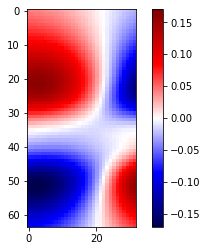

In [ ]:
imshow_center(set_dict[0.025]['train_images_t2b'][33,:,:,0])
# plt.savefig('training_sample.png')

The 33rd battery's magnetic field generated from the `-4` distance.

In [ ]:
print((set_dict[0.025]['train_labels_t2b']).shape)
print((set_dict[0.025]['train_labels_t2b'][33,:,:,0]).shape)
print((set_dict[0.025]['train_labels_t2b'][33,:,:,1]).shape)
print((set_dict[0.025]['train_labels_t2b'][33,:,:,2]).shape)


(180, 32, 16, 3)
(32, 16)
(32, 16)
(32, 16)


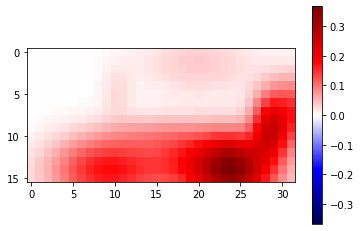

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(set_dict[0.025]['train_labels_t2b'][33,:,:,2]))
plt.savefig('label_sample.png')

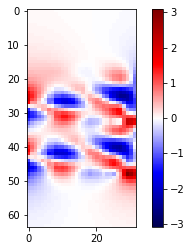

In [ ]:
imshow_center(set_dict[0.005]['train_images_t2b'][33,:,:,0])
# plt.savefig('training_sample.png')

In [ ]:
print((set_dict[0.005]['train_labels_t2b'][33,:,:,0]).shape)
print((set_dict[0.005]['train_labels_t2b'][33,:,:,1]).shape)
print((set_dict[0.005]['train_labels_t2b'][33,:,:,2]).shape)
print((set_dict[0.005]['train_labels_t2b']).shape)

(32, 16)
(32, 16)
(32, 16)
(180, 32, 16, 3)


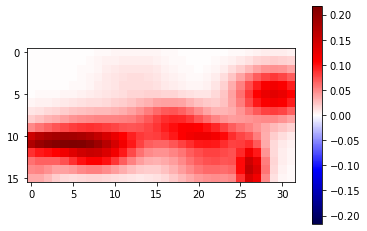

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(set_dict[0.005]['train_labels_t2b'][33,:,:,2]))
# os.mkdir('0.005')
# plt.savefig('0.005/label_sample.png')

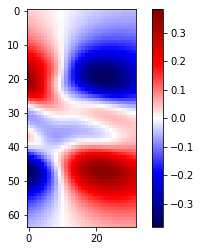

In [ ]:
imshow_center(set_dict[0.015]['train_images_t2b'][33,:,:,0])
# plt.savefig('training_sample.png')

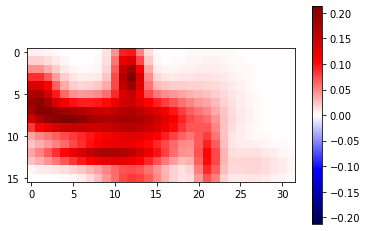

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(set_dict[0.015]['train_labels_t2b'][33,:,:,2]))
# plt.savefig('label_sample.png')

we see a pattern that the larger the `probe_dist`, the smaller the changes in the magnetic field.

## plot average of generated suscept/field vs. `probe_dist`

since different `probe_dist` will generate different ranges of values for `mag_field`, if we want to scale them to be between `-1~1`, we need to first look at their ranges.

In [ ]:
set_dict.keys()

dict_keys([0.005, 0.01, 0.015, 0.02, 0.025])

In [ ]:
set_dict[0.025].keys()

dict_keys(['train_images_t2b', 'train_labels_t2b', 'val_images_t2b', 'val_labels_t2b', 'test_images_t2b', 'test_labels_t2b'])

In [ ]:
A=['input_field', 'input_field', 'input_field', 'input_field', 'output_suscept', 'output_suscept', 'output_suscept']
B=['min', 'mean', 'RMS-mean', 'max', 'min', 'mean', 'max']

[i for i in zip(A,B)]

[('input_field', 'min'),
 ('input_field', 'mean'),
 ('input_field', 'RMS-mean'),
 ('input_field', 'max'),
 ('output_suscept', 'min'),
 ('output_suscept', 'mean'),
 ('output_suscept', 'max')]

In [ ]:
C=np.empty((len(set_dict.keys()),7))
i=0
for dist in set_dict.keys():

  C[i,0] = (np.min(set_dict[dist]['train_images_t2b']))
  C[i,1] = (np.mean(set_dict[dist]['train_images_t2b']))
  C[i,2] = (np.sqrt(np.mean(np.square(set_dict[dist]['train_images_t2b']))))
  C[i,3] = (np.max(set_dict[dist]['train_images_t2b']))

  C[i,4] = (np.min(set_dict[dist]['train_labels_t2b']))
  C[i,5] = (np.mean(set_dict[dist]['train_labels_t2b']))
  C[i,6] = (np.max(set_dict[dist]['train_labels_t2b']))

  i+=1

In [ ]:
df = pd.DataFrame(data=C, columns=pd.MultiIndex.from_tuples(zip(A,B)), index=set_dict.keys())
df

input_field                      ... output_suscept                    
              min      mean  RMS-mean  ...            min      mean       max
0.005  -19.444371 -0.028247  1.654980  ...            0.0  0.018502  0.475010
0.010   -4.508306 -0.030782  0.513183  ...            0.0  0.018292  0.505934
0.015   -1.761819 -0.029597  0.256118  ...            0.0  0.018632  0.546906
0.020   -0.781347 -0.026248  0.153500  ...            0.0  0.018012  0.459327
0.025   -0.438886 -0.024426  0.109820  ...            0.0  0.018407  0.438479

[5 rows x 7 columns]

# Model setup
model based on papers (Bollman, etc) with some modifications, links given

## define model functions

In [ ]:
def get_figure():
    """
    Returns:
      an emtpy figure and an empty axis objects to plot on. 
    
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

def conv_block_h2(input_tensor, num_filters, dropout_level = 0.05):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Dropout(dropout_level)(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block_h2(input_tensor, num_filters, dropout_level = 0.05):
    encoder = layers.BatchNormalization()(input_tensor) # added a first normalization layer
    encoder = conv_block_h2(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block_h2(input_tensor, concat_tensor, num_filters, dropout_level = 0.05):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Dropout(dropout_level)(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder



## define loss functions

In [ ]:
def custom_loss_mse(y_true,y_pred):
    loss=K.mean(K.square(y_pred-y_true),axis=None)  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

def custom_loss_rmse(y_true,y_pred):
    loss=K.sqrt(K.mean(K.square(y_pred-y_true),axis=None))  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

def custom_loss_abs(y_true,y_pred):
    loss=K.mean(K.abs(y_pred-y_true),axis=None)  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

# 'Grid Search' (but really, just use 1 set of the best parameters) model on different datasets

In [ ]:
[i*64 for i in range(4,0,-1)]

[256, 192, 128, 64]

In [ ]:
dist=-2
str(dist)+'/test_20_difference.png'

'-2/test_20_difference.png'

In [ ]:
def grid_search(train_images_t2b, train_labels_t2b, val_images_t2b, val_labels_t2b, cur_path,
                dropout_level_lst=[0.05], beta2_lst=[0.999], beta1_lst=[0.9], lr_rate_lst = [0.001],
                epsilon_lst=[1e-08], epo_lst = [3000], bat_size_lst = [512]
                ):
  # initialize values
  val_loss = np.inf
  best_params = dict()
  dir=cur_path

  for dp_level in dropout_level_lst:
    inputs_h2 = layers.Input(shape=(64,32,2))
    # same as (rscale, cscale, 2)
    # also same as the dimension for EACH image in the training set
    encoder0_pool_h2, encoder0_h2 = encoder_block_h2(inputs_h2, 8, dropout_level=dp_level)
    encoder1_pool_h2, encoder1_h2 = encoder_block_h2(encoder0_pool_h2, 16, dropout_level=dp_level)
    encoder2_pool_h2, encoder2_h2 = encoder_block_h2(encoder1_pool_h2, 32, dropout_level=dp_level)
    encoder3_pool_h2, encoder3_h2 = encoder_block_h2(encoder2_pool_h2, 64, dropout_level=dp_level)
    center_h2 = conv_block_h2(encoder3_pool_h2, 128, dropout_level=dp_level)
    decoder3_h2 = decoder_block_h2(center_h2, encoder3_h2, 64, dropout_level=dp_level)
    decoder2_h2 = decoder_block_h2(decoder3_h2, encoder2_h2, 32, dropout_level=dp_level)
    decoder1_h2 = decoder_block_h2(decoder2_h2, encoder1_h2, 16, dropout_level=dp_level)
    outputs_h2 = layers.Conv2D(3, (1, 1), padding="same")(decoder1_h2)   # simply set number of output channels here, seems legit

    model_ht2b = models.Model(inputs=[inputs_h2], outputs=[outputs_h2])

    for beta2 in beta2_lst:
      for beta1 in beta1_lst:
        for lr_rate in lr_rate_lst:
          for eps in epsilon_lst:
            adam=keras.optimizers.Adam() # use all default values
                                         # so, just use one value as a place holder in your grid search for all Adam parameter values

            model_ht2b.compile(optimizer=adam,
                               loss=custom_loss_rmse) # let's use rmse for optimization becuase it is a bigger target than mse

            # construct checkpoint for saving the best model for current training
            curr_best_filepath=str(dir)+"/current.best.h5"
            checkpoint = ModelCheckpoint(curr_best_filepath, 
                                        monitor='val_loss', # this must be the same string as a metric from your model training verbose output
                                        verbose=1, 
                                        save_best_only=True, # only save the model if it out-performs all previous ones
                                        mode='min', # we want minimum loss
                                        save_weights_only=False # we want to save the entire model, not just the weights
                                        )
            callbacks_list = [checkpoint]

            for epo in epo_lst:
              for bat_size in bat_size_lst:
                start = time.time()
                history_ht2b = model_ht2b.fit(train_images_t2b, 
                                              train_labels_t2b,
                                              validation_data = (val_images_t2b, val_labels_t2b),  
                                              epochs=epo, 
                                              batch_size=bat_size, 
                                              shuffle=True,
                                              callbacks = callbacks_list,
                                              verbose=1)
                training_time = time.time()-start
                
                # load best model from current training b/c the best model might not be the last model
                model_ht2b = tf.keras.models.load_model(curr_best_filepath, 
                                                        custom_objects={'custom_loss_rmse': custom_loss_rmse})
                new_loss = custom_loss_rmse(val_labels_t2b, model_ht2b.predict(val_images_t2b))
                
                if new_loss.numpy() < val_loss:
                  print()
                  print('final validation loss decreased from ', val_loss, ' to ', new_loss.numpy())
                  print('saving the current best model as the overall best model')
                  print(100*'*')
                  val_loss = new_loss.numpy()
                  
                  best_params['best_dropout_rate'] = dp_level
                  best_params['best_beta_2'] = beta2
                  best_params['best_beta_1'] = beta1
                  best_params['best_learning_rate'] = lr_rate
                  best_params['best_epsilon'] = eps
                  best_params['best_epochs'] = epo
                  best_params['best_batch_size'] = bat_size

                  best_params['best_val_loss_reached'] = val_loss
                  best_params['training_time'] = training_time
                  best_params['val_loss_his'] = history_ht2b.history['val_loss']
                  best_params['train_loss_his'] = history_ht2b.history['loss']
                    # comment these out for now because they take way too much space when printed out 
                  
                  # save the best overall grid-searched model found so far 
                  best_filepath = str(dir)+'/model.best.h5'
                  model_ht2b.save(best_filepath)
                  
                  # save history of validation-loss from the best model to observe epochs effect
                  with open(str(dir)+'/best_val_loss_history.db', 'wb') as file_pi:
                    pk.dump(history_ht2b.history['val_loss'], file_pi)
                  # later open with 
                  # val_loss_history_ht2b = pk.load(open('best_val_loss_history.db', "rb"))

                  # save history of training-loss from the best model to observe epochs effect
                  with open(str(dir)+'/best_train_loss_history.db', 'wb') as file_pi:
                    pk.dump(history_ht2b.history['loss'], file_pi)
                  # later open with 
                  # train_loss_history_ht2b = pk.load(open('best_train_loss_history.db', "rb"))

                  # save the best_params dictionary along the way incase training gets killed mid-way and the function doesn't get to finish
                  # "w" mode automatically overwrites if the file already exists
                  param_json = json.dumps(best_params)
                  f = open(str(dir)+'/best_params.json',"w")
                  f.write(param_json)
                  f.close()

                  # save a plot of the val_loss_history for the best performing model for observation
                  fig, ax = get_figure()
                  fig.set_size_inches(20,10)
                  num_epochs=len(history_ht2b.history['val_loss'])
                  startpoints=0
                  ax.set_yscale('log') # set y-axis to log_10 scale for better viewing
                  ax.plot((np.arange(num_epochs*1)+1)[startpoints:], 
                          history_ht2b.history['loss'][startpoints:], 
                          linewidth=1, color="orange", 
                          label="training_loss")
                  ax.plot((np.arange(num_epochs*1)+1)[startpoints:], 
                          history_ht2b.history['val_loss'][startpoints:], 
                          linewidth=1, color="blue", 
                          label="validation loss")
                  ax.set_xlabel('epochs')
                  ax.set_ylabel('log loss')
                  ax.legend(frameon=False);
                  fig.savefig(str(dir)+'/best_model_loss_history.png')
                else:
                  print('final validation loss did not decrease for this set of parameters')
                  print('current overall best model and parameters does not get updated')
                  print(100*'*')
  return best_params

In [ ]:
set_dict[0.025].keys()

dict_keys(['train_images_t2b', 'train_labels_t2b', 'val_images_t2b', 'val_labels_t2b', 'test_images_t2b', 'test_labels_t2b'])

In [ ]:
set_dict.keys()

dict_keys([0.005, 0.01, 0.015, 0.02, 0.025])

In [ ]:
# !rm -r *

In [ ]:
os.mkdir('sub/subsub')

In [ ]:
result_dict = dict()
dp_list = [0.05, 0.10, 0.15]

for dist in set_dict.keys():
  for dp_rate in dp_list:
    cur_path=str(dp_rate)+'dp'+ '/'+str(dist)+'dist'
    print(cur_path)
    specs_dict = dict()
    
    try:
      os.mkdir(str(dp_rate)+'dp')
    except:
      print("directory already exists")

    try:
      os.mkdir(str(cur_path)) # make a directory before we can put things under it
    except:
      print("directory already exists")

    best_params = grid_search(set_dict[dist]['train_images_t2b'], set_dict[dist]['train_labels_t2b'],
                              set_dict[dist]['val_images_t2b'], set_dict[dist]['val_labels_t2b'], cur_path = cur_path,
                              dropout_level_lst = [dp_rate], epo_lst=[30], bat_size_lst=[128])
    
    specs_dict['best_val_loss_reached'] = best_params['best_val_loss_reached']
    specs_dict['training_time'] = best_params['training_time']
    specs_dict['val_loss_his'] = best_params['val_loss_his']
    specs_dict['train_loss_his'] = best_params['train_loss_his']

    # predict w the best model, or in this case, only 1 model, on the test set
    model_ht2b=tf.keras.models.load_model(str(cur_path)+'/model.best.h5',
                                          custom_objects={'custom_loss_rmse': custom_loss_rmse})
    
    # in-sample -------------------------------------------------------------------------------------------------------------------------------------

    susax=2
    train_images_t2b = set_dict[dist]['train_images_t2b']
    train_labels_t2b = set_dict[dist]['train_labels_t2b']
    X_train = train_images_t2b
    y_pred_ht2 = model_ht2b.predict(train_images_t2b)

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax])
    plt.title("predicted susceptibility for the 20th battery in train set")
    plt.savefig(cur_path+"/train_20_pred.png")
    plt.close()

    plt.figure()
    imshow_center(train_labels_t2b[20,:,:,susax])
    plt.title("actual susceptibility for the 20th battery in train set")
    plt.savefig(cur_path+"/train_20_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax]-train_labels_t2b[20,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/train_20_error.png")
    plt.close()

    train_diff = train_labels_t2b - y_pred_ht2
    train_diff = tf.keras.backend.flatten(train_diff)
    plt.figure(figsize=(15,7))
    plt.hist(train_diff, bins=30, density=True, label='difference');
    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 60)
    kde = stats.gaussian_kde(train_diff)
    plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    plt.legend(loc="upper left")
    plt.ylabel('Probability')
    plt.xlabel('difference')
    range = np.max([np.abs(np.min(train_diff)), np.abs(np.max(train_diff))])
    plt.xlim(-range, range)
    plt.title("Histogram of differences");
    plt.savefig(cur_path+"/train_diff_hist.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[20,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_train[20,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/train_20_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_train[20,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/train_20_zfield_diff.png")
    plt.close()

    # calculate final train loss ------------

    final_loss = custom_loss_rmse(train_labels_t2b, y_pred_ht2)
    print('final RMSE loss on train set:', final_loss.numpy())
    NRMSE = final_loss/K.mean(train_labels_t2b)
    print('final normalized RMSE loss (div mean) on the train set:', NRMSE.numpy())
    RMSE_range = final_loss /(tf.reduce_max(train_labels_t2b) - tf.reduce_min(train_labels_t2b))
    print('final normalized RMSE loss (div range) on the train set:', RMSE_range.numpy())
    train_arr = tf.keras.backend.flatten(train_labels_t2b).numpy()
    IQR = stats.iqr(train_arr)
    RMSE_IQR = final_loss/IQR
    print('final normalized RMSE loss (div IQR) on the train set:', RMSE_IQR.numpy())
    Boll_NRMSE = tf.norm(y_pred_ht2-train_labels_t2b) / tf.norm(train_labels_t2b)
    print('final Bollman normalized RMSE loss on the train set:', Boll_NRMSE.numpy())

    specs_dict['train_final_RMSE'] = final_loss.numpy()
    specs_dict['train_final_NRMSE'] = NRMSE.numpy()
    specs_dict['train_final_RMSE_range'] = RMSE_range.numpy()
    specs_dict['train_final_RMSE_IQR'] = RMSE_IQR.numpy()
    specs_dict['train_final_Boll_NRMSE'] = Boll_NRMSE.numpy()

    # view final loss per battery ----------

    Boll_NRMSE_train_lst = []

    for i in np.arange(int(train_labels_t2b.shape[0])):
      # print(i)
      Boll_NRMSE = (tf.norm(y_pred_ht2[i,:,:,:]-train_labels_t2b[i,:,:,:]) 
                    / tf.norm(train_labels_t2b[i,:,:,:]))
      Boll_NRMSE_train_lst.append(Boll_NRMSE)

    plt.figure(figsize=(15,7))
    plt.plot(Boll_NRMSE_train_lst, label="Boll_NRMSE per battery")
    plt.legend()
    plt.xlabel("battery #")
    plt.ylabel("Boll_NRMSE")
    plt.savefig(cur_path+"/train_Boll_NRMSE_per_battery.png")
    plt.close()

    # -------------------------------------------

    best_batt = np.argmin(Boll_NRMSE_train_lst)
    best_batt_NRMSE = min(Boll_NRMSE_train_lst).numpy()
    print("The best predicted battery is battery ", best_batt, "from the train set with a Boll_NRMSE of ", best_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(best_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_best_pred.png")
    plt.close()

    plt.figure()
    imshow_center(train_labels_t2b[best_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(best_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_best_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax]-train_labels_t2b[best_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/train_best_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[best_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_train[best_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/train_best_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_train[best_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/train_best_zfield_diff.png")
    plt.close()

    # -------------------------------------------

    worst_batt = np.argmax(Boll_NRMSE_train_lst)
    worst_batt_NRMSE = max(Boll_NRMSE_train_lst).numpy()
    print("The worst predicted battery is battery", worst_batt, "from the train set with a Boll_NRMSE of ", worst_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(worst_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_worst_pred.png")
    plt.close()

    plt.figure()
    imshow_center(train_labels_t2b[worst_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(worst_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_worst_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax]-train_labels_t2b[worst_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/train_worst_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[worst_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_train[worst_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/train_worst_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_train[worst_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/train_worst_zfield_diff.png")
    plt.close()

    print("are predictions for the two different batteries different?" ,
          np.all(y_pred_ht2[worst_batt,:,:,susax] == y_pred_ht2[best_batt,:,:,susax]) == False)

    # out-of-sample ----------------------------------------------------------------------------------------------------------------------

    susax=2
    test_images_t2b = set_dict[dist]['test_images_t2b']
    test_labels_t2b = set_dict[dist]['test_labels_t2b']
    X_test = test_images_t2b
    y_pred_ht2 = model_ht2b.predict(test_images_t2b)

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax])
    plt.title("predicted susceptibility for the 20th battery in test set")
    plt.savefig(cur_path+"/test_20_pred.png")
    plt.close()

    plt.figure()
    imshow_center(test_labels_t2b[20,:,:,susax])
    plt.title("actual susceptibility for the 20th battery in test set")
    plt.savefig(cur_path+"/test_20_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax]-test_labels_t2b[20,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/test_20_error.png")
    plt.close()

    test_diff = test_labels_t2b - y_pred_ht2
    test_diff = tf.keras.backend.flatten(test_diff)
    plt.figure(figsize=(15,7))
    plt.hist(test_diff, bins=30, density=True, label='difference');
    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 60)
    kde = stats.gaussian_kde(test_diff)
    plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    plt.legend(loc="upper left")
    plt.ylabel('Probability')
    plt.xlabel('difference')
    range = np.max([np.abs(np.min(test_diff)), np.abs(np.max(test_diff))])
    plt.xlim(-range, range)
    plt.title("Histogram of differences");
    plt.savefig(cur_path+"/test_diff_hist.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[20,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_test[20,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/test_20_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_test[20,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/test_20_zfield_diff.png")
    plt.close()

    # calculate final test loss ------------

    final_loss = custom_loss_rmse(test_labels_t2b, y_pred_ht2)
    print('final RMSE loss on test set:', final_loss.numpy())
    NRMSE = final_loss/K.mean(test_labels_t2b)
    print('final normalized RMSE loss (div mean) on the test set:', NRMSE.numpy())
    RMSE_range = final_loss /(tf.reduce_max(test_labels_t2b) - tf.reduce_min(test_labels_t2b))
    print('final normalized RMSE loss (div range) on the test set:', RMSE_range.numpy())
    test_arr = tf.keras.backend.flatten(test_labels_t2b).numpy()
    IQR = stats.iqr(test_arr)
    RMSE_IQR = final_loss/IQR
    print('final normalized RMSE loss (div IQR) on the test set:', RMSE_IQR.numpy())
    print('final norm of the difference tensor:', tf.norm(y_pred_ht2-test_labels_t2b).numpy())
    Boll_NRMSE = tf.norm(y_pred_ht2-test_labels_t2b) / tf.norm(test_labels_t2b)
    print('final Bollman normalized RMSE loss on the test set:', Boll_NRMSE.numpy())

    specs_dict['test_final_RMSE'] = final_loss.numpy()
    specs_dict['test_final_NRMSE'] = NRMSE.numpy()
    specs_dict['test_final_RMSE_range'] = RMSE_range.numpy()
    specs_dict['test_final_RMSE_IQR'] = RMSE_IQR.numpy()
    specs_dict['test_final_Boll_NRMSE'] = Boll_NRMSE.numpy()

    # view final loss per battery ----------
    Boll_NRMSE_test_lst = []

    for i in np.arange(int(test_labels_t2b.shape[0])):
      # print(i)
      Boll_NRMSE = (tf.norm(y_pred_ht2[i,:,:,:]-test_labels_t2b[i,:,:,:]) 
                    / tf.norm(test_labels_t2b[i,:,:,:]))
      Boll_NRMSE_test_lst.append(Boll_NRMSE)

    plt.figure(figsize=(15,7))
    plt.plot(Boll_NRMSE_test_lst, label="Boll_NRMSE per battery")
    plt.legend()
    plt.xlabel("battery #")
    plt.ylabel("Boll_NRMSE")
    plt.savefig(cur_path+"/test_Boll_NRMSE_per_battery.png")
    plt.close()

    # -------------------------------------------

    best_batt = np.argmin(Boll_NRMSE_test_lst)
    best_batt_NRMSE = min(Boll_NRMSE_test_lst).numpy()
    print("The best predicted battery is battery", best_batt, "from the test set with a Boll_NRMSE of ", best_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(best_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_best_pred.png")
    plt.close()

    plt.figure()
    imshow_center(test_labels_t2b[best_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(best_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_best_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax]-test_labels_t2b[best_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/test_best_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[best_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_test[best_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/test_best_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_test[best_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/test_best_zfield_diff.png")
    plt.close()

    # -------------------------------------------

    worst_batt = np.argmax(Boll_NRMSE_test_lst)
    worst_batt_NRMSE = max(Boll_NRMSE_test_lst).numpy()
    print("The worst predicted battery is battery", worst_batt, "from the test set with a Boll_NRMSE of ", worst_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(worst_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_worst_pred.png")
    plt.close()

    plt.figure()
    imshow_center(test_labels_t2b[worst_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(worst_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_worst_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax]-test_labels_t2b[worst_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/test_worst_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[worst_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_test[worst_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/test_worst_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_test[worst_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/test_worst_zfield_diff.png")
    plt.close()

    print("are predictions for the two different batteries different?" ,
          np.all(y_pred_ht2[worst_batt,:,:,susax] == y_pred_ht2[best_batt,:,:,susax]) == False)
    
    # save specs to result dictionary
    result_dict[cur_path] = specs_dict

    print(100*'|')

In [ ]:
result_dict.keys()

dict_keys(['0.05dp/0.005dist', '0.1dp/0.005dist', '0.15dp/0.005dist', '0.05dp/0.01dist', '0.1dp/0.01dist', '0.15dp/0.01dist', '0.05dp/0.015dist', '0.1dp/0.015dist', '0.15dp/0.015dist', '0.05dp/0.02dist', '0.1dp/0.02dist', '0.15dp/0.02dist', '0.05dp/0.025dist', '0.1dp/0.025dist', '0.15dp/0.025dist'])

In [ ]:
assert len(result_dict.keys()) == len(dp_list) * len(set_dict.keys())

In [ ]:
assert len(result_dict['0.1dp/0.02dist'].keys()) == 14
# there should be 14 different specs for each distance 

## plot the fianl test `Boll_NRMSE` across the different trials

In [ ]:
result_dict.keys()

dict_keys(['0.05dp/0.005dist', '0.1dp/0.005dist', '0.15dp/0.005dist', '0.05dp/0.01dist', '0.1dp/0.01dist', '0.15dp/0.01dist', '0.05dp/0.015dist', '0.1dp/0.015dist', '0.15dp/0.015dist', '0.05dp/0.02dist', '0.1dp/0.02dist', '0.15dp/0.02dist', '0.05dp/0.025dist', '0.1dp/0.025dist', '0.15dp/0.025dist'])

In [ ]:
result_dict['0.05dp/0.005dist'].keys()

dict_keys(['best_val_loss_reached', 'training_time', 'val_loss_his', 'train_loss_his', 'train_final_RMSE', 'train_final_NRMSE', 'train_final_RMSE_range', 'train_final_RMSE_IQR', 'train_final_Boll_NRMSE', 'test_final_RMSE', 'test_final_NRMSE', 'test_final_RMSE_range', 'test_final_RMSE_IQR', 'test_final_Boll_NRMSE'])

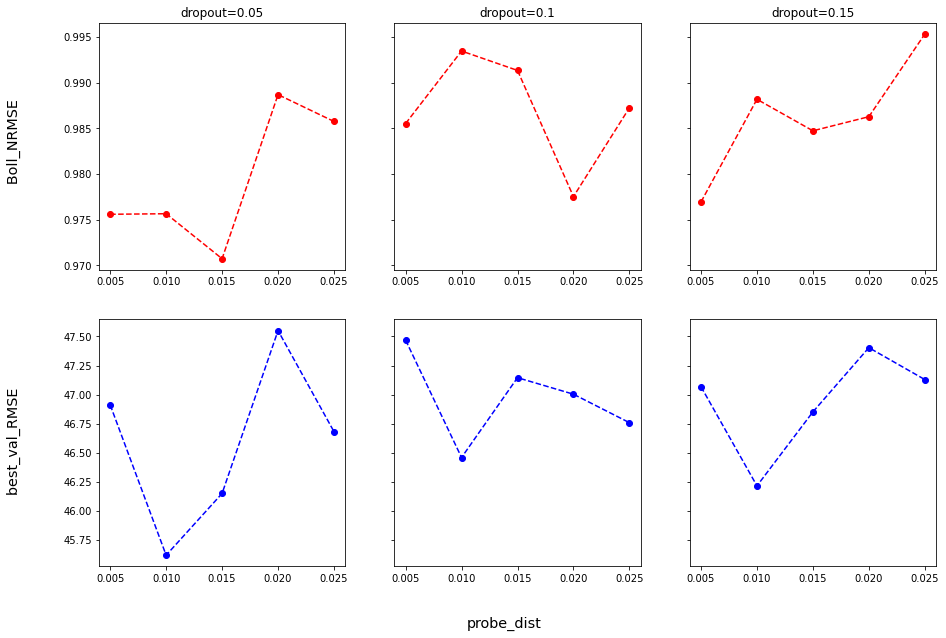

In [ ]:
fig,axs = plt.subplots(2,3, sharey='row')
fig.set_size_inches(15,10)
fig.text(0.5, 0.04, 'probe_dist', ha='center', size='x-large')
fig.text(0.04, 0.5, 'best_val_RMSE                                            Boll_NRMSE',
         va='center', rotation='vertical', size='x-large')
i=0

 
for dp in dp_list:
  Boll_NRMSE_lst = []
  best_val_loss_lst=[]
  x=[]

  for dist in dist_list:
    key = str(dp)+'dp/'+str(dist)+'dist'
    x.append(dist)
    Boll_NRMSE_lst.append(result_dict[key]['test_final_Boll_NRMSE'])
    best_val_loss_lst.append(result_dict[key]['best_val_loss_reached'])

  axs[0,i].plot(x, Boll_NRMSE_lst, label="test_Boll_NRMSE", linestyle='--', marker='o', color="red") 
  axs[1,i].plot(x, best_val_loss_lst, label="best_val_loss", linestyle='--', marker='o', color="blue") 
  axs[0,i].set_title("dropout="+str(dp))
  # axs[i].set_yscale("log")
  i= i+1

fig.savefig("dist_VS_loss.png")

In [ ]:
try:
  # save the final result dictionary
  # bc earlier versions of python does not support 'with' statement we have to do this?
  result_json = json.dumps(result_dict)
  f = open("result_dict.json","w")
  f.write(result_json)
  f.close()
  print('saved result dictionary')
  # load the json file later with
  # f = open("result_dict.json", "r")
  # try:
  #     result_dict = json.load(f)
  # finally:
  #     f.close()
except:
  print('could not save result dictionary')

saved result dictionary


In [ ]:
# predict w the best model, or in this case, only 1 model, on the test set
    model_ht2b=tf.keras.models.load_model(str(cur_path)+'/model.best.h5',
                                          custom_objects={'custom_loss_rmse': custom_loss_rmse})
    
    # in-sample -------------------------------------------------------------------------------------------------------------------------------------

    susax=2
    train_images_t2b = set_dict[dist]['train_images_t2b']
    train_labels_t2b = set_dict[dist]['train_labels_t2b']
    X_train = train_images_t2b
    y_pred_ht2 = model_ht2b.predict(train_images_t2b)

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax])
    plt.title("predicted susceptibility for the 20th battery in train set")
    plt.savefig(cur_path+"/train_20_pred.png")
    plt.close()

    plt.figure()
    imshow_center(train_labels_t2b[20,:,:,susax])
    plt.title("actual susceptibility for the 20th battery in train set")
    plt.savefig(cur_path+"/train_20_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax]-train_labels_t2b[20,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/train_20_error.png")
    plt.close()

    train_diff = train_labels_t2b - y_pred_ht2
    train_diff = tf.keras.backend.flatten(train_diff)
    plt.figure(figsize=(15,7))
    plt.hist(train_diff, bins=30, density=True, label='difference');
    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 60)
    kde = stats.gaussian_kde(train_diff)
    plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    plt.legend(loc="upper left")
    plt.ylabel('Probability')
    plt.xlabel('difference')
    range = np.max([np.abs(np.min(train_diff)), np.abs(np.max(train_diff))])
    plt.xlim(-range, range)
    plt.title("Histogram of differences");
    plt.savefig(cur_path+"/train_diff_hist.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[20,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_train[20,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/train_20_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_train[20,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/train_20_zfield_diff.png")
    plt.close()

    # calculate final train loss ------------

    final_loss = custom_loss_rmse(train_labels_t2b, y_pred_ht2)
    print('final RMSE loss on train set:', final_loss.numpy())
    NRMSE = final_loss/K.mean(train_labels_t2b)
    print('final normalized RMSE loss (div mean) on the train set:', NRMSE.numpy())
    RMSE_range = final_loss /(tf.reduce_max(train_labels_t2b) - tf.reduce_min(train_labels_t2b))
    print('final normalized RMSE loss (div range) on the train set:', RMSE_range.numpy())
    train_arr = tf.keras.backend.flatten(train_labels_t2b).numpy()
    IQR = stats.iqr(train_arr)
    RMSE_IQR = final_loss/IQR
    print('final normalized RMSE loss (div IQR) on the train set:', RMSE_IQR.numpy())
    Boll_NRMSE = tf.norm(y_pred_ht2-train_labels_t2b) / tf.norm(train_labels_t2b)
    print('final Bollman normalized RMSE loss on the train set:', Boll_NRMSE.numpy())

    specs_dict['train_final_RMSE'] = final_loss.numpy()
    specs_dict['train_final_NRMSE'] = NRMSE.numpy()
    specs_dict['train_final_RMSE_range'] = RMSE_range.numpy()
    specs_dict['train_final_RMSE_IQR'] = RMSE_IQR.numpy()
    specs_dict['train_final_Boll_NRMSE'] = Boll_NRMSE.numpy()

    # view final loss per battery ----------

    Boll_NRMSE_train_lst = []

    for i in np.arange(int(train_labels_t2b.shape[0])):
      # print(i)
      Boll_NRMSE = (tf.norm(y_pred_ht2[i,:,:,:]-train_labels_t2b[i,:,:,:]) 
                    / tf.norm(train_labels_t2b[i,:,:,:]))
      Boll_NRMSE_train_lst.append(Boll_NRMSE)

    plt.figure(figsize=(15,7))
    plt.plot(Boll_NRMSE_train_lst, label="Boll_NRMSE per battery")
    plt.legend()
    plt.xlabel("battery #")
    plt.ylabel("Boll_NRMSE")
    plt.savefig(cur_path+"/train_Boll_NRMSE_per_battery.png")
    plt.close()

    # -------------------------------------------

    best_batt = np.argmin(Boll_NRMSE_train_lst)
    best_batt_NRMSE = min(Boll_NRMSE_train_lst).numpy()
    print("The best predicted battery is battery ", best_batt, "from the train set with a Boll_NRMSE of ", best_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(best_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_best_pred.png")
    plt.close()

    plt.figure()
    imshow_center(train_labels_t2b[best_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(best_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_best_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax]-train_labels_t2b[best_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/train_best_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[best_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_train[best_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/train_best_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_train[best_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/train_best_zfield_diff.png")
    plt.close()

    # -------------------------------------------

    worst_batt = np.argmax(Boll_NRMSE_train_lst)
    worst_batt_NRMSE = max(Boll_NRMSE_train_lst).numpy()
    print("The worst predicted battery is battery", worst_batt, "from the train set with a Boll_NRMSE of ", worst_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(worst_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_worst_pred.png")
    plt.close()

    plt.figure()
    imshow_center(train_labels_t2b[worst_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(worst_batt)+" battery in train set")
    plt.savefig(cur_path+"/train_worst_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax]-train_labels_t2b[worst_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/train_worst_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[worst_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_train[worst_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/train_worst_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_train[worst_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/train_worst_zfield_diff.png")
    plt.close()

    print("are predictions for the two different batteries different?" ,
          np.all(y_pred_ht2[worst_batt,:,:,susax] == y_pred_ht2[best_batt,:,:,susax]) == False)

    # out-of-sample ----------------------------------------------------------------------------------------------------------------------

    susax=2
    test_images_t2b = set_dict[dist]['test_images_t2b']
    test_labels_t2b = set_dict[dist]['test_labels_t2b']
    X_test = test_images_t2b
    y_pred_ht2 = model_ht2b.predict(test_images_t2b)

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax])
    plt.title("predicted susceptibility for the 20th battery in test set")
    plt.savefig(cur_path+"/test_20_pred.png")
    plt.close()

    plt.figure()
    imshow_center(test_labels_t2b[20,:,:,susax])
    plt.title("actual susceptibility for the 20th battery in test set")
    plt.savefig(cur_path+"/test_20_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[20,:,:,susax]-test_labels_t2b[20,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/test_20_error.png")
    plt.close()

    test_diff = test_labels_t2b - y_pred_ht2
    test_diff = tf.keras.backend.flatten(test_diff)
    plt.figure(figsize=(15,7))
    plt.hist(test_diff, bins=30, density=True, label='difference');
    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 60)
    kde = stats.gaussian_kde(test_diff)
    plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    plt.legend(loc="upper left")
    plt.ylabel('Probability')
    plt.xlabel('difference')
    range = np.max([np.abs(np.min(test_diff)), np.abs(np.max(test_diff))])
    plt.xlim(-range, range)
    plt.title("Histogram of differences");
    plt.savefig(cur_path+"/test_diff_hist.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[20,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_test[20,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/test_20_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_test[20,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/test_20_zfield_diff.png")
    plt.close()

    # calculate final test loss ------------

    final_loss = custom_loss_rmse(test_labels_t2b, y_pred_ht2)
    print('final RMSE loss on test set:', final_loss.numpy())
    NRMSE = final_loss/K.mean(test_labels_t2b)
    print('final normalized RMSE loss (div mean) on the test set:', NRMSE.numpy())
    RMSE_range = final_loss /(tf.reduce_max(test_labels_t2b) - tf.reduce_min(test_labels_t2b))
    print('final normalized RMSE loss (div range) on the test set:', RMSE_range.numpy())
    test_arr = tf.keras.backend.flatten(test_labels_t2b).numpy()
    IQR = stats.iqr(test_arr)
    RMSE_IQR = final_loss/IQR
    print('final normalized RMSE loss (div IQR) on the test set:', RMSE_IQR.numpy())
    print('final norm of the difference tensor:', tf.norm(y_pred_ht2-test_labels_t2b).numpy())
    Boll_NRMSE = tf.norm(y_pred_ht2-test_labels_t2b) / tf.norm(test_labels_t2b)
    print('final Bollman normalized RMSE loss on the test set:', Boll_NRMSE.numpy())

    specs_dict['test_final_RMSE'] = final_loss.numpy()
    specs_dict['test_final_NRMSE'] = NRMSE.numpy()
    specs_dict['test_final_RMSE_range'] = RMSE_range.numpy()
    specs_dict['test_final_RMSE_IQR'] = RMSE_IQR.numpy()
    specs_dict['test_final_Boll_NRMSE'] = Boll_NRMSE.numpy()

    # view final loss per battery ----------
    Boll_NRMSE_test_lst = []

    for i in np.arange(int(test_labels_t2b.shape[0])):
      # print(i)
      Boll_NRMSE = (tf.norm(y_pred_ht2[i,:,:,:]-test_labels_t2b[i,:,:,:]) 
                    / tf.norm(test_labels_t2b[i,:,:,:]))
      Boll_NRMSE_test_lst.append(Boll_NRMSE)

    plt.figure(figsize=(15,7))
    plt.plot(Boll_NRMSE_test_lst, label="Boll_NRMSE per battery")
    plt.legend()
    plt.xlabel("battery #")
    plt.ylabel("Boll_NRMSE")
    plt.savefig(cur_path+"/test_Boll_NRMSE_per_battery.png")
    plt.close()

    # -------------------------------------------

    best_batt = np.argmin(Boll_NRMSE_test_lst)
    best_batt_NRMSE = min(Boll_NRMSE_test_lst).numpy()
    print("The best predicted battery is battery", best_batt, "from the test set with a Boll_NRMSE of ", best_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(best_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_best_pred.png")
    plt.close()

    plt.figure()
    imshow_center(test_labels_t2b[best_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(best_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_best_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[best_batt,:,:,susax]-test_labels_t2b[best_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/test_best_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[best_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_test[best_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/test_best_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_test[best_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/test_best_zfield_diff.png")
    plt.close()

    # -------------------------------------------

    worst_batt = np.argmax(Boll_NRMSE_test_lst)
    worst_batt_NRMSE = max(Boll_NRMSE_test_lst).numpy()
    print("The worst predicted battery is battery", worst_batt, "from the test set with a Boll_NRMSE of ", worst_batt_NRMSE)

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax])
    plt.title("predicted susceptibility for the "+str(worst_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_worst_pred.png")
    plt.close()

    plt.figure()
    imshow_center(test_labels_t2b[worst_batt,:,:,susax])
    plt.title("actual susceptibility for the "+str(worst_batt)+" battery in test set")
    plt.savefig(cur_path+"/test_worst_true.png")
    plt.close()

    plt.figure()
    imshow_center(y_pred_ht2[worst_batt,:,:,susax]-test_labels_t2b[worst_batt,:,:,susax])
    # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
    # we want this difference to be as small as possible, not too extreme in either way
    plt.title("error between predicted and true susceptibility")
    plt.savefig(cur_path+"/test_worst_error.png")
    plt.close()

    yf,zf=calcfield(y_pred_ht2[worst_batt,:,:,:], A_dict[dist])
    # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
    # from the predicted susceptibility output
    # so we are kind of like recreating the input to see if it is the same as the actual input
    # to see if the model learned the dipole forward kernel well

    plt.figure()
    imshow_center(np.squeeze(X_test[worst_batt,:,:,0])-yf)
    plt.title("error between forwardly solved y-field from prediction and true input y-field")
    plt.savefig(cur_path+"/test_worst_yfield_diff.png")
    plt.close()

    plt.figure()
    imshow_center(np.squeeze(X_test[worst_batt,:,:,1])-zf)
    plt.title("error between forwardly solved z-field from prediction and true input z-field")
    plt.savefig(cur_path+"/test_worst_zfield_diff.png")
    plt.close()

    print("are predictions for the two different batteries different?" ,
          np.all(y_pred_ht2[worst_batt,:,:,susax] == y_pred_ht2[best_batt,:,:,susax]) == False)
    
    # save specs to result dictionary
    result_dict[cur_path] = specs_dict

    print(100*'|')